In [1]:
import pandas as pd
import pymysql
import logging
import sshtunnel
from sshtunnel import SSHTunnelForwarder
import os.path
import matplotlib.pyplot as plt

In [2]:
# You will need to add your SSH public key and database password to connect.
ssh_host = 'vfsmghnecweb01.fsm.northwestern.edu'
ssh_username = 'efa3001'
db_server = 'vfsmghnecdb01.fsm.northwestern.edu'
database_username = 'efa3001'
ssh_pkey = 'C:\\Users\\16262\\Desktop\\NCDS-NEC_Data_Internship\\5-16-privkey-openSSH'
database_password = 'E%H2)h.nPevc<a>&'
database_name = 'nec_dw'
localhost = '127.0.0.1'

In [3]:
def open_ssh_tunnel(verbose=False):
    """Open an SSH tunnel and connect using a username and password.
    
    :param verbose: Set to True to show logging
    :return tunnel: Global SSH tunnel connection
    """
    
    if verbose:
        sshtunnel.DEFAULT_LOGLEVEL = logging.DEBUG
    
    global tunnel
    tunnel = SSHTunnelForwarder(
        (ssh_host, 22),
        ssh_username = ssh_username,
        ssh_pkey = ssh_pkey,
        remote_bind_address = (db_server, 3306)
    )
    
    tunnel.start()

In [4]:
def mysql_connect():
    """Connect to a MySQL server using the SSH tunnel connection
    
    :return connection: Global MySQL database connection
    """
    
    global connection
    
    connection = pymysql.connect(
        host = localhost,
        user = database_username,
        passwd = database_password,
        db = database_name,
        port = tunnel.local_bind_port
    )

In [5]:
def run_query(sql):
    """Runs a given SQL query via the global database connection.
    
    :param sql: MySQL query
    :return: Pandas dataframe containing results
    """
    
    return pd.read_sql_query(sql, connection)

In [6]:
def mysql_disconnect():
    """Closes the MySQL database connection.
    """
    
    connection.close()

In [7]:
def close_ssh_tunnel():
    """Closes the SSH tunnel connection.
    """
    
    tunnel.close

In [8]:
open_ssh_tunnel()

In [9]:
mysql_connect()

In [10]:
#Below: Exploring the relationship between Funding and Success Ratings for Staff Activities

In [11]:
#grabbing Staff Activities table
staffact_df = run_query("SELECT * FROM StaffActivities")
staffact_df.head()

,ActivityID,Title,Description,RegionOfficeID,StartDate,EndDate,ActivityWasConductedOnline,ActivityWasConductedInPerson,County,ActivityHowSuccessfulID,...,TrainingWasProvided,AddressStreet,AddressApartmentSuite,AddressCity,AddressState,Zip,116CongressDistrict,GeocodedLatitude,GeocodedLongitude,ModifiedDate
0,9649,PubMed Training; Merck staff training; 2/14/2019,Purpose is to introduce PubMed to Merck staff;...,3.0,2019-02-14,2019-02-14,1.0,0.0,Allegheny,4.0,...,1.0,200 Scaife Hall,3550 Terrace St.,Pittsburgh,PA,15261,Unavailable,0.00000,0.000000,2020-03-05
1,9664,LAPL El Sereno Mental Health Support Group,Nora Franco conducted a site visit to the El S...,13.0,2019-01-16,2019-01-16,0.0,1.0,Los Angeles,4.0,...,0.0,5226 Huntington Dr S,,Los Angeles,CA,90032,Congressional District 34,34.08951,-118.168655,2020-03-05
2,9665,LAPL El Sereno Mental Health Support Group,Nora Franco conducted a follow-up site visit t...,13.0,2019-02-26,2019-02-26,0.0,1.0,Los Angeles,5.0,...,0.0,5226 Huntington Dr S,,Los Angeles,CA,90032,Congressional District 34,34.08951,-118.168655,2020-03-05
3,9666,MedlinePlus training-Los Angeles,One on one MedlinePlus training with nursing s...,13.0,2019-02-06,2019-02-06,0.0,1.0,Los Angeles,5.0,...,1.0,Ronald Reagan UCLA Medical Center,757 Westwood Plaza,Los Angeles,CA,90095,Unavailable,0.00000,0.000000,2020-03-05
4,9667,Serving Diverse Communities: Finding Data on H...,"An online, asynchronous course designed to int...",2.0,2019-03-01,2019-03-01,1.0,0.0,Johnson,4.0,...,1.0,600 Newton Road,,Iowa City,IA,52242,Congressional District 2,41.66302,-91.547540,2020-03-05


In [12]:
#removing null success values
staffact_success_df = staffact_df[staffact_df["ActivityHowSuccessfulID"] > 0.0]

In [13]:
#checking if each activity ID is unique
unique_activity = staffact_success_df["ActivityID"].unique()
len(unique_activity)
#yes!

3734

In [14]:
#looking specifically at activity ID, success, and non-NLM funding amount
staffact_success_funds_df = staffact_success_df[["ActivityID","ActivityHowSuccessfulID","NonNLMFundingAmount"]]
staffact_success_funds_df

,ActivityID,ActivityHowSuccessfulID,NonNLMFundingAmount
0,9649,4.0,0.0
1,9664,4.0,0.0
2,9665,5.0,0.0
3,9666,5.0,0.0
4,9667,4.0,0.0
...,...,...,...
3729,33844,5.0,0.0
3730,33846,5.0,0.0
3731,33848,3.0,0.0
3732,33850,3.0,0.0


In [15]:
#How is nonNLMFundingAmount per success rank?
describe_fund_success = staffact_success_funds_df.groupby(["ActivityHowSuccessfulID"])["NonNLMFundingAmount"].describe()
describe_fund_success
#note the count distribution of success ratings.

,count,mean,std,min,25%,50%,75%,max
ActivityHowSuccessfulID,,,,,,,,
1.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2.0,27.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3.0,485.0,0.494845,10.897839,0.0,0.0,0.0,0.0,240.0
4.0,2133.0,3.383029,91.999761,0.0,0.0,0.0,0.0,3434.0
5.0,1087.0,13.477461,232.223901,0.0,0.0,0.0,0.0,5300.0


In [16]:
#Below: looking at funding and success for subaward activities

In [17]:
#join ProjectFunding to Projects to SubawardActivities
#grabbing Subaward Activites, Projects, and Project Funding Tables
subact_df, proj_df, proj_fund_df = run_query("SELECT * FROM SubawardActivities"), run_query("SELECT * FROM Projects"), run_query("SELECT * FROM ProjectFunding")

In [18]:
proj_df

,ProjectID,Title,FundingSourceRegionID,ProjectSummary,LeadOrganizationID,ProjectLead,ProjectManager,StartDate,EndDate,Status,Category,ModifiedDate,ActivitiesNotCompleted,ProjectCannotBeCompleted,NoCostExtension
0,9630,All of Us - The All of Us Research Program and...,3,The National Institutes of Health and the Nati...,19488.0,56234,47261,2018-05-15,2019-04-30,Completed,Outreach,2020-03-05,None,None,None
1,9651,Seeds of Hope,3,The Clinton-Essex-Franklin Library System (CEF...,12937.0,20830,53431,2018-05-15,2019-04-30,Completed,Outreach,2020-03-05,None,None,None
2,9683,Resources and Services for Community Health Nu...,13,To support community health nurses across the ...,12021.0,,,2018-05-01,2019-04-30,Completed,Outreach,2021-04-15,None,None,None
3,9687,Clinical and Public Health Approaches for Comm...,3,Southwest Pennsylvania Environmental Health Pr...,15611.0,42803,45591,2018-07-23,2019-04-30,Completed,Outreach,2020-03-05,None,None,None
4,9698,Arizona Outreach (2016-2021),13,This project focuses on key health priorities ...,18335.0,,,2018-05-01,2020-04-30,Completed,Outreach,2021-04-15,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5327,1016881,Community Health Outreach: Collaborate - Commu...,12,DESCRIPTION: Host a one-day Interprofessional ...,12628.0,,,2018-07-01,2019-03-01,,Outreach,2019-01-01,None,None,None
5328,1016882,Data Engagement: Using Hands-on Workshops to P...,12,DESCRIPTION: Create a suite of workshops that ...,11582.0,,,2018-08-27,2019-04-30,,,2019-01-01,None,None,None
5329,1016883,Data Engagement: Data Visualization Lab at Was...,12,DESCRIPTION: Improve the value of research pro...,12931.0,,,2018-09-01,2019-04-30,,,2019-01-01,None,None,None
5330,1016884,Technology Improvement: ASSIST Laptops for Nei...,12,DESCRIPTION: By obtaining extra laptops the AS...,19576.0,,,2018-10-01,2019-09-30,,Improvement,2019-01-01,None,None,None


In [19]:
#checking if a project has multiple activities... yes!
len(subact_df["ProjectID"].unique())
#how to split success rating by different activities from same funding?
#1. try: success rating average for activities belonging to the same project and fund?

995

In [20]:
#projectfunding is separated into columns by year, so a project may span several years.
#for projects that span several years, do success ratings improve with funding?

In [21]:
#group projects into mean funding and add Project ID
mean_proj_fund_df = proj_fund_df.groupby(["ProjectID"])["FundingAmount"].mean().to_frame()
title_proj_df = run_query("SELECT ProjectID, Title FROM Projects")
projects_and_mean_funding_df = mean_proj_fund_df.merge(title_proj_df, how = "left", on = "ProjectID")
projects_and_mean_funding_df

,ProjectID,FundingAmount,Title
0,9630,16070.0,All of Us - The All of Us Research Program and...
1,9651,4941.0,Seeds of Hope
2,9683,20000.0,Resources and Services for Community Health Nu...
3,9687,16338.0,Clinical and Public Health Approaches for Comm...
4,9698,40445.5,Arizona Outreach (2016-2021)
...,...,...,...
5311,1016881,15165.0,Community Health Outreach: Collaborate - Commu...
5312,1016882,9500.0,Data Engagement: Using Hands-on Workshops to P...
5313,1016883,8644.0,Data Engagement: Data Visualization Lab at Was...
5314,1016884,5000.0,Technology Improvement: ASSIST Laptops for Nei...


In [22]:
#what are the top five and lowest five projects (that are not 0) in funding per year?
projects_and_mean_funding_df.sort_values("FundingAmount", ascending = False)[projects_and_mean_funding_df["FundingAmount"] > 0]

,ProjectID,FundingAmount,Title
5191,1016287,1.743835e+06,Connect to your Health Wellness Fair
2207,1003494,1.655812e+06,National Network of Libraries of Medicine Sout...
4828,1013322,1.555585e+06,"NN/LM South Central Region, 2016-2021"
3431,1005001,1.498588e+06,National Network of Libraries of Medicine Sout...
4813,1013032,1.484613e+06,NN/LM Pacific NW Region 2016-2021
...,...,...,...
2826,1004249,1.000000e+00,PSR Outreach Connections
2895,1004334,1.000000e+00,Developing HIV Leaders in the Philadelphia She...
2887,1004325,1.000000e+00,Improving Access to HIV/AIDS Health Informatio...
3632,1005238,1.000000e+00,Utilization of National Library of Medicine Re...


In [23]:
#what is the relationship between mean project funding (across years) to project's mean activity success rating?
subact_df = run_query("SELECT ActivityID, ProjectID, ActivityHowSuccessfulID FROM SubawardActivities")
subact_success_df = subact_df[subact_df["ActivityHowSuccessfulID"]>0]
subact_mean_success_df = subact_success_df.groupby("ProjectID")["ActivityHowSuccessfulID"].mean().to_frame()
subact_fund_mean_success_df = subact_mean_success_df.merge(projects_and_mean_funding_df, how = "inner", on = "ProjectID")
subact_fund_mean_success_df.sort_values("FundingAmount", ascending = False)

,ProjectID,ActivityHowSuccessfulID,FundingAmount,Title
416,30397.0,4.000000,261930.0,Citizen Science Month 2021
419,31469.0,3.666667,163993.0,Health and Wellness Conversations at Your Library
377,28243.0,4.000000,138805.5,AgriSafeHealthHub (AHH)
245,17467.0,3.179487,102708.5,Employing Community Wellness Liaisons to Creat...
264,19867.0,3.240000,100394.0,JUNTOS por su SALUD: Librarians and Health Pro...
...,...,...,...,...
12,9755.0,4.500000,0.0,Partner Outreach 2018-2021: University of Loui...
14,9762.0,4.000000,0.0,Partner Outreach 2018-2021: University of Nort...
15,9765.0,3.500000,0.0,Partner Outreach 2018-2021: University of Wisc...
16,9772.0,4.333333,0.0,Partner Outreach 2018-2021: University of Cinc...


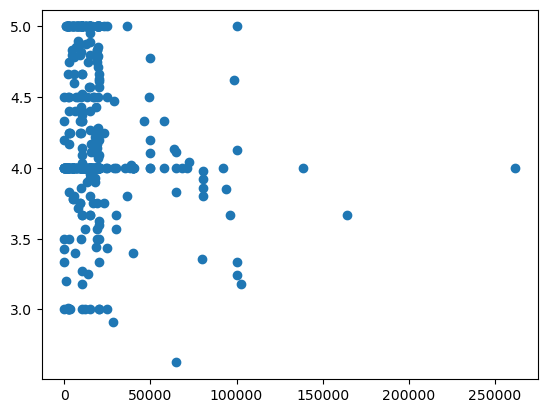

In [25]:
plt.scatter(subact_fund_mean_success_df["FundingAmount"], subact_fund_mean_success_df["ActivityHowSuccessfulID"])

In [ ]:
#PLOT IS: 
#looks like funding does not directly impact success? Maybe success rating is too biased?

In [ ]:
#most frequent words in description per success level?
#what about most frequent words in "Evaluation", "Impact", "LessonsLearned", or "ProblemsOrBarriersEncountered" in reports table?
#remove <p> from above columns^

In [ ]:
mysql_disconnect()
close_ssh_tunnel()

In [ ]:
# # Write the data frame to a tab-separated text file

# import os  

# file_path = "C:\\Users\\16262\\Desktop\\nec-internship-project"

# if not os.path.exists(file_path):
#     os.mkdir(file_path)

# output_file = 'NNLM_final_reports_sample.tsv'
# complete_fn = os.path.join(file_path, output_file)
# df.to_csv(complete_fn, sep = '\t',index=False)